/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


WIB: Run 1, Episode 50, Episode Reward: 93.0, Average Reward: 29.66
WIB: Run 1, Episode 100, Episode Reward: 162.0, Average Reward: 52.73
WIB: Run 1, Episode 150, Episode Reward: 196.0, Average Reward: 162.17
WIB: Run 1, Episode 200, Episode Reward: 188.0, Average Reward: 256.25
WIB: Run 1, Episode 250, Episode Reward: 500.0, Average Reward: 304.68
WIB: Run 1, Episode 300, Episode Reward: 500.0, Average Reward: 408.83
WIB: Run 1, Episode 350, Episode Reward: 500.0, Average Reward: 483.24
WIB: Run 1, Episode 400, Episode Reward: 206.0, Average Reward: 485.87
WIB: Run 1, Episode 450, Episode Reward: 500.0, Average Reward: 486.03
WIB: Run 1, Episode 500, Episode Reward: 500.0, Average Reward: 486.45
WIB: Run 2, Episode 50, Episode Reward: 16.0, Average Reward: 25.96
WIB: Run 2, Episode 100, Episode Reward: 211.0, Average Reward: 40.7
WIB: Run 2, Episode 150, Episode Reward: 393.0, Average Reward: 130.6
WIB: Run 2, Episode 200, Episode Reward: 500.0, Average Reward: 293.03
WIB: Run 2, Epis

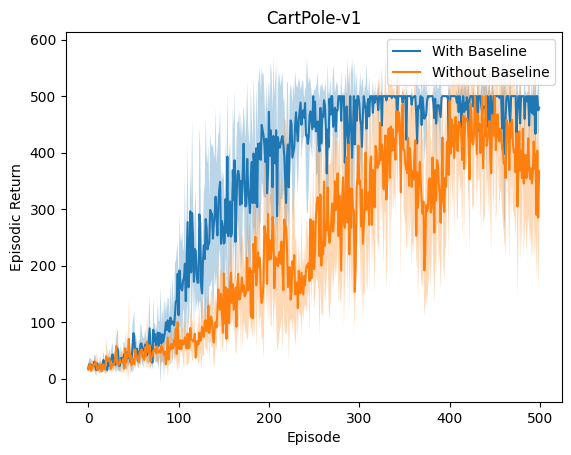

WIB: Run 1, Episode 50, Episode Reward: -208.0, Average Reward: -291.88
WIB: Run 1, Episode 100, Episode Reward: -169.0, Average Reward: -236.35
WIB: Run 1, Episode 150, Episode Reward: -182.0, Average Reward: -171.97
WIB: Run 1, Episode 200, Episode Reward: -99.0, Average Reward: -151.45
WIB: Run 1, Episode 250, Episode Reward: -136.0, Average Reward: -133.92
WIB: Run 1, Episode 300, Episode Reward: -102.0, Average Reward: -122.76
WIB: Run 1, Episode 350, Episode Reward: -77.0, Average Reward: -111.78
WIB: Run 1, Episode 400, Episode Reward: -101.0, Average Reward: -110.94
WIB: Run 1, Episode 450, Episode Reward: -92.0, Average Reward: -109.55
WIB: Run 1, Episode 500, Episode Reward: -110.0, Average Reward: -103.0
WIB: Run 2, Episode 50, Episode Reward: -231.0, Average Reward: -309.68
WIB: Run 2, Episode 100, Episode Reward: -150.0, Average Reward: -242.67
WIB: Run 2, Episode 150, Episode Reward: -120.0, Average Reward: -162.24
WIB: Run 2, Episode 200, Episode Reward: -131.0, Average 

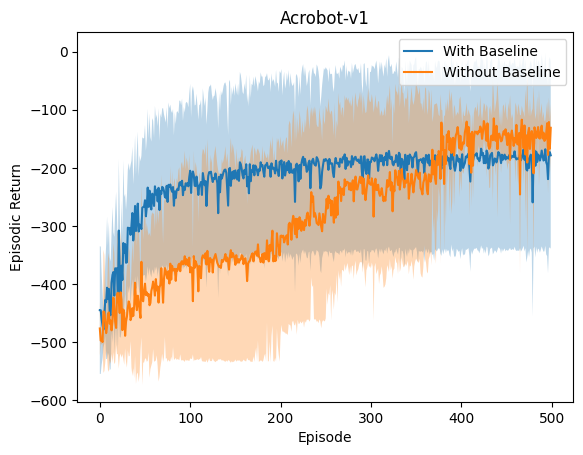

In [ ]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init

# Policy network
class PolicyNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super(PolicyNetwork, self).__init__()
        self.fc = nn.Linear(input_size, 256)
        self.relu = nn.ReLU()
        self.output = nn.Linear(256, output_size)
        self.softmax = nn.Softmax(dim=1)

        self.initialize_parameters()

    def initialize_parameters(self):
      for layer in [self.fc, self.output]:
          init.xavier_uniform_(layer.weight)
          init.constant_(layer.bias, 0)

    def forward(self, x):
        x = self.fc(x)
        x = self.relu(x)
        x = self.output(x)
        return self.softmax(x)


# State-value network (for baseline)
class ValueNetwork(nn.Module):
    def __init__(self, input_size):
        super(ValueNetwork, self).__init__()
        self.fc = nn.Linear(input_size, 256)
        self.relu = nn.ReLU()
        self.output = nn.Linear(256, 1)

        # Initialize parameters
        self.initialize_parameters()

    def initialize_parameters(self):
        for layer in [self.fc, self.output]:
            init.xavier_uniform_(layer.weight)
            init.constant_(layer.bias, 0)

    def forward(self, x):
        x = self.fc(x)
        x = self.relu(x)
        x = self.output(x)
        return x


# MC REINFORCE algorithm without baseline
def mc_reinforce_without_baseline(env_name, num_episodes, max_episode_length, gamma, learning_rate):
    env = gym.make(env_name)
    input_size = env.observation_space.shape[0]
    output_size = env.action_space.n

    episode_returns = []

    for seed in range(5):
        policy_network = PolicyNetwork(input_size, output_size)
        optimizer = optim.Adam(policy_network.parameters(), lr=learning_rate)
        returns = []
        np.random.seed(seed)
        torch.manual_seed(seed)
        for episode in range(num_episodes):
            log_probs = []
            rewards = []
            state = env.reset()
            episode_reward = 0
            for t in range(max_episode_length):
                state = torch.FloatTensor(state).unsqueeze(0)
                action_probs = policy_network(state)
                action_dist = torch.distributions.Categorical(action_probs)
                action = action_dist.sample()
                log_prob = action_dist.log_prob(action)
                log_probs.append(log_prob)
                next_state, reward, done, _ = env.step(action.item())
                rewards.append(reward)
                episode_reward += reward
                state = next_state
                if done or t == max_episode_length - 1:
                    discounted_returns = []
                    G = 0
                    for reward in reversed(rewards):
                        G = gamma * G + reward
                        discounted_returns.append(G)
                    discounted_returns.reverse()

                    policy_loss = []
                    for log_prob, G in zip(log_probs, discounted_returns):
                        policy_loss.append(-log_prob * G)
                    policy_loss = torch.stack(policy_loss).sum()

                    optimizer.zero_grad()
                    policy_loss.backward()
                    optimizer.step()

                    returns.append(episode_reward)
                    #print(f"Episode {episode + 1}, Loss: {policy_loss.item()}, Total Reward: {episode_reward}, Average Reward: {np.mean(returns[-100:])}")
                    if (episode + 1) % 50 == 0:
                        print(f"WOB: Run {seed+1}, Episode {episode + 1}, Episode Reward: {episode_reward}, Average Reward: {np.mean(returns[-100:])}")
                    break

        episode_returns.append(returns)
    return episode_returns


# MC REINFORCE algorithm with baseline
def mc_reinforce_with_baseline(env_name, num_episodes, max_episode_length, gamma, learning_rate, learning_rate_v):
    env = gym.make(env_name)
    input_size = env.observation_space.shape[0]
    output_size = env.action_space.n

    episode_returns = []

    for seed in range(5):
        policy_network = PolicyNetwork(input_size, output_size)
        value_network = ValueNetwork(input_size)
        policy_optimizer = optim.Adam(policy_network.parameters(), lr=learning_rate)
        value_optimizer = optim.Adam(value_network.parameters(), lr=learning_rate_v)
        returns = []
        np.random.seed(seed)
        torch.manual_seed(seed)
        for episode in range(num_episodes):
            log_probs = []
            rewards = []
            states = []
            state = env.reset()
            episode_reward = 0
            for t in range(max_episode_length):
                state = torch.FloatTensor(state).unsqueeze(0)
                action_probs = policy_network(state)
                action_dist = torch.distributions.Categorical(action_probs)
                action = action_dist.sample()
                log_prob = action_dist.log_prob(action)
                log_probs.append(log_prob)
                states.append(state)
                next_state, reward, done, _ = env.step(action.item())
                rewards.append(reward)
                episode_reward += reward
                state = next_state
                if done or t == max_episode_length - 1:
                    discounted_returns = []
                    G = 0
                    for reward in reversed(rewards):
                        G = gamma * G + reward
                        discounted_returns.append(G)
                    discounted_returns.reverse()

                    policy_loss = []
                    value_loss = 0
                    for log_prob, G, state in zip(log_probs, discounted_returns, states):
                        state_value = value_network(state)
                        advantage = G - state_value.item()  # Calculate advantage using baseline
                        policy_loss.append(-log_prob * advantage)
                        value_loss += (G - state_value)**2  # TD(0) update for the baseline
                    policy_loss = torch.stack(policy_loss).sum()
                    value_loss /= len(states)

                    policy_optimizer.zero_grad()
                    value_optimizer.zero_grad()
                    policy_loss.backward()
                    value_loss.backward()
                    policy_optimizer.step()
                    value_optimizer.step()

                    returns.append(episode_reward)
                    #print(f"Episode {episode + 1}, Loss: {policy_loss.item()}, Total Reward: {episode_reward}, Average Reward: {np.mean(returns[-100:])}")
                    if (episode + 1) % 50 == 0:
                        print(f"WIB: Run {seed+1}, Episode {episode + 1}, Episode Reward: {episode_reward}, Average Reward: {np.mean(returns[-100:])}")
                    break

        episode_returns.append(returns)

    return episode_returns

# Function to plot mean and variance of episodic returns
def plot_results(env_name, episode_returns_with_baseline, episode_returns_without_baseline):
    mean_returns_with_baseline = np.mean(episode_returns_with_baseline, axis=0)
    std_returns_with_baseline = np.std(episode_returns_with_baseline, axis=0)

    mean_returns_without_baseline = np.mean(episode_returns_without_baseline, axis=0)
    std_returns_without_baseline = np.std(episode_returns_without_baseline, axis=0)

    plt.plot(mean_returns_with_baseline, label='With Baseline')
    plt.fill_between(range(len(mean_returns_with_baseline)), mean_returns_with_baseline - std_returns_with_baseline, mean_returns_with_baseline + std_returns_with_baseline, alpha=0.3)

    plt.plot(mean_returns_without_baseline, label='Without Baseline')
    plt.fill_between(range(len(mean_returns_without_baseline)), mean_returns_without_baseline - std_returns_without_baseline, mean_returns_without_baseline + std_returns_without_baseline, alpha=0.3)

    plt.title(env_name)
    plt.xlabel('Episode')
    plt.ylabel('Episodic Return')
    plt.legend()
    plt.show()

# Set hyperparameters
gamma = 0.99
learning_rate = 0.001
learning_rate_v = 0.01
num_episodes = 500
max_episode_length = 500

# Run experiments for CartPole-v1 environment
cartpole_returns_with_baseline = mc_reinforce_with_baseline('CartPole-v1', num_episodes, max_episode_length, gamma, learning_rate, learning_rate_v)
cartpole_returns_without_baseline = mc_reinforce_without_baseline('CartPole-v1', num_episodes, max_episode_length, gamma, learning_rate)
plot_results('CartPole-v1', np.array(cartpole_returns_with_baseline), np.array(cartpole_returns_without_baseline))


# Run experiments for Acrobot-v1 environment
acrobot_returns_with_baseline = mc_reinforce_with_baseline('Acrobot-v1', num_episodes, max_episode_length, gamma, learning_rate, learning_rate_v)
acrobot_returns_without_baseline = mc_reinforce_without_baseline('Acrobot-v1', num_episodes, max_episode_length, gamma, learning_rate)
plot_results('Acrobot-v1', np.array(acrobot_returns_with_baseline), np.array(acrobot_returns_without_baseline))
